**Objectives:**

The goal of this task is to:

1. **Scrape product data** from Amazon.in for a specific keyword.
2. **Analyze the data** to extract meaningful and actionable insights.
3. Present the analysis with **clear visualizations** and explanations.

#Amazon Scraping

In [1]:
pip install requests beautifulsoup4 pandas numpy matplotlib selenium webdriver-manager

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.4/9.4 MB 25.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 499.2/499.2 kB 13.5 MB/s eta 0:00:00


In [14]:
# %% [markdown]
# ## **1. Proper Setup for Colab**

# %%
# Install required packages
!pip install selenium beautifulsoup4 pandas numpy matplotlib webdriver-manager
!apt-get update
!apt-get install -y chromium-chromedriver

# Set up the correct Chrome version
!wget https://dl.google.com/linux/direct/google-chrome-stable_current_amd64.deb
!dpkg -i google-chrome-stable_current_amd64.deb
!apt --fix-broken install -y

Hit:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:2 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:3 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:4 http://archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:5 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:6 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:7 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:10 https://dl.google.com/linux/chrome/deb stable InRelease
Hit:11 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Reading package lists... Done
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Reading

In [16]:
# %%
# Import libraries
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.by import By
from webdriver_manager.chrome import ChromeDriverManager
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import re


%matplotlib inline

Selenium Webdriver

In [17]:

def setup_driver():
    """Proper Chrome WebDriver configuration for Colab"""
    chrome_options = webdriver.ChromeOptions()
    chrome_options.add_argument('--headless')
    chrome_options.add_argument('--no-sandbox')
    chrome_options.add_argument('--disable-dev-shm-usage')
    chrome_options.add_argument('--disable-gpu')
    chrome_options.add_argument('--remote-debugging-port=9222')

    # Use webdriver-manager to handle the correct ChromeDriver version
    service = Service(ChromeDriverManager().install())

    driver = webdriver.Chrome(service=service, options=chrome_options)
    return driver

Verification

In [18]:

try:
    driver = setup_driver()
    driver.get("https://www.google.com")
    print("WebDriver successfully initialized! Page title:", driver.title)
    driver.quit()
except Exception as e:
    print("Error initializing WebDriver:", str(e))

WebDriver successfully initialized! Page title: Google


Scrapping

In [63]:
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.common.by import By
from selenium.webdriver.support import expected_conditions as EC
from bs4 import BeautifulSoup
import pandas as pd
import time
import re
from webdriver_manager.chrome import ChromeDriverManager

def setup_driver():
    """Configure Chrome WebDriver with optimized settings"""
    chrome_options = Options()
    chrome_options.add_argument('--headless=new')
    chrome_options.add_argument('--no-sandbox')
    chrome_options.add_argument('--disable-dev-shm-usage')
    chrome_options.add_argument('--window-size=1920,1080')
    chrome_options.add_argument('user-agent=Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/120.0.0.0 Safari/537.36')
    chrome_options.add_argument('--disable-blink-features=AutomationControlled')
    chrome_options.add_experimental_option('excludeSwitches', ['enable-automation'])

    service = Service(ChromeDriverManager().install())
    driver = webdriver.Chrome(service=service, options=chrome_options)
    return driver

def is_sponsored(product):
    """More inclusive sponsored product detection"""
    sponsored_markers = [
        'sponsored', 'promoted', 'ad', 'featured',
        'sp-sponsored-result', 's-sponsored-result',
        'aok-align-center', 's-sponsored'
    ]

    # Check both attributes and text content
    for marker in sponsored_markers:
        has_marker_in_attr = product.get('data-component-type', '').lower() == marker
        has_marker_in_class = any(marker in cls.lower() for cls in product.get('class', []))
        has_marker_in_text = bool(product.find(string=re.compile(marker, re.I)))

        if has_marker_in_attr or has_marker_in_class or has_marker_in_text:
            return True
    return False

def extract_title(product):
    """More aggressive title extraction"""
    title_elem = (product.find('h2') or
                product.find('span', class_=re.compile('a-size-')) or
                product.find('a', class_=re.compile('text-normal')))
    return title_elem.text.strip() if title_elem else "Title Not Found"

def extract_brand(product):
    """Advanced brand extraction with multiple fallback strategies"""
    # Strategy 1: Dedicated brand element (most reliable)
    brand_elem = product.find('span', class_=re.compile(r'brand|maker|manufacturer', re.I))
    if brand_elem:
        brand = brand_elem.text.strip()
        if not re.search(r'\d+[+]|bought|purchased|rated|m\.r\.p', brand, re.I):
            return re.sub(r'^(Brand:|by|Visit the|Store|Shop)\s*', '', brand, flags=re.I).strip()

    # Strategy 2: First word from title (common pattern)
    title = extract_title(product)
    first_word = title.split()[0] if title else ""
    if (len(first_word) > 2 and
        not first_word.isdigit() and
        not re.search(r'[0-9+]', first_word)):
        return first_word

    # Strategy 3: Second word if first is common prefix
    if len(title.split()) > 1:
        second_word = title.split()[1]
        if (len(second_word) > 2 and
            not second_word.isdigit() and
            not re.search(r'[0-9+]', second_word)):
            return second_word

    # Strategy 4: Look for brand in product URL
    url_elem = product.find('a', href=True)
    if url_elem:
        url = url_elem['href']
        if '/dp/' in url:
            brand_part = url.split('/dp/')[0].split('/')[-1]
            if len(brand_part) > 2:
                return brand_part.replace('-', ' ').title()

    return "Unknown Brand"

def extract_price(product):
    """More resilient price extraction"""
    price_elem = (product.find('span', class_='a-price-whole') or
                 product.find('span', class_='a-offscreen') or
                 product.find('span', class_=re.compile('price')))
    if price_elem:
        try:
            return float(re.sub(r'[^\d.]', '', price_elem.text))
        except:
            return None
    return None

def extract_rating(product):
    """More flexible rating extraction"""
    rating_elem = product.find('span', class_=re.compile('a-icon-alt|rating'))
    if rating_elem and 'out of' in rating_elem.text:
        try:
            return float(rating_elem.text.split()[0])
        except:
            return None
    return None

def extract_reviews(product):
    """More comprehensive reviews extraction"""
    reviews_elem = product.find('span', class_=re.compile('review|rating-count'))
    if reviews_elem:
        try:
            return int(re.sub(r'[^\d]', '', reviews_elem.text))
        except:
            return 0
    return 0

def scrape_amazon_products(search_term, pages=3):
    """Optimized scraping function with increased product capture"""
    driver = setup_driver()
    base_url = "https://www.amazon.in"
    all_products = []

    try:
        for page in range(1, pages + 1):
            url = f"{base_url}/s?k={search_term.replace(' ', '+')}&page={page}"
            print(f"Scraping page {page}: {url}")

            driver.get(url)
            # Wait longer and for more elements
            WebDriverWait(driver, 20).until(
                EC.presence_of_all_elements_located((By.CSS_SELECTOR, "div.s-result-item"))
            )

            # More thorough scrolling
            for i in range(5):
                driver.execute_script("window.scrollTo(0, document.body.scrollHeight*{}/5);".format(i+1))
                time.sleep(1.5)

            soup = BeautifulSoup(driver.page_source, 'html.parser')
            products = soup.find_all('div', class_=re.compile('s-result-item'))

            for product in products:
                if not is_sponsored(product):
                    continue

                product_data = extract_product_data(product, base_url)
                if product_data:
                    all_products.append(product_data)
                    print(f"Found: {product_data['Brand']} - {product_data['Title'][:50]}...")

    except Exception as e:
        print(f"Scraping failed: {str(e)}")
    finally:
        driver.quit()

    return pd.DataFrame(all_products)

def extract_product_data(product, base_url):
    """Complete data extraction with maximum coverage"""
    try:
        return {
            'Title': extract_title(product),
            'Brand': extract_brand(product),
            'Price': extract_price(product),
            'Rating': extract_rating(product),
            'Reviews': extract_reviews(product),
            'Image_URL': product.find('img', class_=re.compile('s-image'))['src'] if product.find('img', class_=re.compile('s-image')) else None,
            'Product_URL': f"{base_url}{product.find('a')['href']}" if product.find('a') else None,
            'Sponsored': True
        }
    except Exception as e:
        print(f"Error extracting product: {str(e)}")
        return None

def save_results(df, filename):
    """Save results with comprehensive validation"""
    if df.empty:
        print("\nNo products found. Please check:")
        print("- Internet connection")
        print("- Amazon blocking")
        print("- HTML structure changes")
        return

    df.to_csv(filename, index=False)
    print(f"\nSuccessfully saved {len(df)} products to {filename}")
    print("\nFirst 5 products:")
    print(df[['Brand', 'Title', 'Price']].head(5))

if __name__ == "__main__":
    print("Starting enhanced Amazon scraper...")
    products_df = scrape_amazon_products("soft toys", pages=3)
    save_results(products_df, "amazon_sponsored_soft_toys.csv")

Starting enhanced Amazon scraper...
Scraping page 1: https://www.amazon.in/s?k=soft+toys&page=1
Found: Babique - Babique Plush Soft ToysBabique Plush Soft Toys...
Found: Storio - Storio Toy Octopus Plushie Reversible Soft Toys fo...
Found: Storio - Storio Toy Plushie Super Soft Toys for Kids | Ador...
Found: Babique - Babique Unicorn Teddy Bear Plush Soft Toy Cute Kid...
Found: Sponsored - DearJoy Big Size Fibre Filled Stuffed Animal Eleph...
Found: Babique - Babique Dog Sitting Plush Soft Toy Cute Kids Anima...
Found: Amazon - Amazon Brand - Jam & Honey Soft Penguin Plush Toy ...
Found: Babique - Babique Elephant Sitting Plush Soft Toy Cute Kids ...
Found: Niku - Niku Rabbit with Chain Reversible Bunny Rabbit Sof...
Found: Babique - Babique Cat Flower Plush Soft Toy Cute Kids Animal...
Found: Babique - Babique Unicorn Teddy Bear Plush Soft Toy Cute Kid...
Found: Storio - Storio Plushie Flying Unicorn | Soft Toys | Birthd...
Found: Storio - Storio Toy Super Cute Plushie Soft Toys for K

#Data Cleaning & Preparation

In [64]:
import pandas as pd
import numpy as np

In [65]:
df = pd.read_csv('amazon_sponsored_soft_toys.csv')

In [66]:
print("Original shape:", df.shape)

Original shape: (166, 8)


In [67]:
df.head()

,Title,Brand,Price,Rating,Reviews,Image_URL,Product_URL,Sponsored
0,Babique Plush Soft ToysBabique Plush Soft Toys,Babique,319.0,NaN,0,NaN,https://www.amazon.inhttps://aax-eu.amazon.in/...,True
1,Storio Toy Octopus Plushie Reversible Soft Toy...,Storio,179.0,4.2,0,https://m.media-amazon.com/images/I/51nqXz7iWr...,https://www.amazon.in/Storio-Octopus-Plushie-R...,True
2,Storio Toy Plushie Super Soft Toys for Kids | ...,Storio,189.0,4.2,0,https://m.media-amazon.com/images/I/61ocDqkDeM...,https://www.amazon.in/Storio-Plushie-Super-Ado...,True
3,Babique Unicorn Teddy Bear Plush Soft Toy Cute...,Babique,169.0,4.1,0,https://m.media-amazon.com/images/I/51AWNa6+TO...,https://www.amazon.in/Babique-Unicorn-Stuffed-...,True
4,DearJoy Big Size Fibre Filled Stuffed Animal E...,Sponsored,560.0,4.3,0,https://m.media-amazon.com/images/I/81S00b+-XM...,https://www.amazon.inhttps://aax-eu.amazon.in/...,True


Remove duplicates.

In [68]:
#  based on Title and Product_URL
before_dedup = len(df)
df = df.drop_duplicates(subset=['Title', 'Product_URL'], keep='first')
after_dedup = len(df)

print(f"Removed {before_dedup - after_dedup} duplicates")
print("Shape after deduplication:", df.shape)
df.head(3)

Removed 0 duplicates
Shape after deduplication: (166, 8)


,Title,Brand,Price,Rating,Reviews,Image_URL,Product_URL,Sponsored
0,Babique Plush Soft ToysBabique Plush Soft Toys,Babique,319.0,NaN,0,NaN,https://www.amazon.inhttps://aax-eu.amazon.in/...,True
1,Storio Toy Octopus Plushie Reversible Soft Toy...,Storio,179.0,4.2,0,https://m.media-amazon.com/images/I/51nqXz7iWr...,https://www.amazon.in/Storio-Octopus-Plushie-R...,True
2,Storio Toy Plushie Super Soft Toys for Kids | ...,Storio,189.0,4.2,0,https://m.media-amazon.com/images/I/61ocDqkDeM...,https://www.amazon.in/Storio-Plushie-Super-Ado...,True


Ensure price, reviews, and ratings are in numerical format.

In [69]:
# Convert Price to numeric (remove ₹ and commas)
df['Price'] = (
    df['Price']
    .astype(str)
    .str.replace('[₹,]', '', regex=True)  # Remove currency symbols
    .replace('', np.nan)  # Convert empty strings to NaN
    .astype(float)  # Convert to float
)

print("Price cleaning summary:")
print("- Null values:", df['Price'].isna().sum())
print("- Min price:", df['Price'].min())
print("- Max price:", df['Price'].max())
df[['Title', 'Price']].head(3)

Price cleaning summary:
- Null values: 8
- Min price: 85.0
- Max price: 3499.0


,Title,Price
0,Babique Plush Soft ToysBabique Plush Soft Toys,319.0
1,Storio Toy Octopus Plushie Reversible Soft Toy...,179.0
2,Storio Toy Plushie Super Soft Toys for Kids | ...,189.0


In [70]:
# Convert and validate ratings (0-5 scale)
df['Rating'] = (
    pd.to_numeric(df['Rating'], errors='coerce')  # Convert to numeric
    .clip(0, 5)  # Force ratings between 0-5
    .fillna(0)  # Fill nulls with 0
)

print("Rating cleaning summary:")
print("- Null values:", df['Rating'].isna().sum())
print("- Average rating:", df['Rating'].mean())
df[['Title', 'Rating']].head(3)

Rating cleaning summary:
- Null values: 0
- Average rating: 3.7897590361445777


,Title,Rating
0,Babique Plush Soft ToysBabique Plush Soft Toys,0.0
1,Storio Toy Octopus Plushie Reversible Soft Toy...,4.2
2,Storio Toy Plushie Super Soft Toys for Kids | ...,4.2


In [71]:
# Convert reviews to integers
df['Reviews'] = (
    df['Reviews']
    .astype(str)
    .str.replace(',', '')  # Remove thousands separators
    .replace('[^0-9]', '', regex=True)  # Keep only digits
    .replace('', '0')  # Replace empty strings with 0
    .astype(int)  # Convert to integer
)

print("Reviews cleaning summary:")
print("- Null values:", df['Reviews'].isna().sum())
print("- Max reviews:", df['Reviews'].max())
df[['Title', 'Reviews']].head(3)

Reviews cleaning summary:
- Null values: 0
- Max reviews: 0


,Title,Reviews
0,Babique Plush Soft ToysBabique Plush Soft Toys,0
1,Storio Toy Octopus Plushie Reversible Soft Toy...,0
2,Storio Toy Plushie Super Soft Toys for Kids | ...,0


Standardize any inconsistent values (e.g., remove ₹ symbols).

In [72]:
# Clean Title column
df['Title'] = (
    df['Title']
    .str.strip()  # Remove whitespace
    .str.replace('\s+', ' ', regex=True)  # Standardize spaces
)

# Clean Brand column
df['Brand'] = (
    df['Brand']
    .str.upper()  # Convert to uppercase
    .str.strip()  # Remove whitespace
    .str.replace('[^A-Z0-9& ]', '', regex=True)  # Remove special chars
)

print("Text standardization complete")
print("Sample Titles:\n", df['Title'].head(3).tolist())
print("\nSample Brands:\n", df['Brand'].head(3).tolist())

Text standardization complete
Sample Titles:
 ['Babique Plush Soft ToysBabique Plush Soft Toys', 'Storio Toy Octopus Plushie Reversible Soft Toys for Kids | Plush Soft Toys for Baby Boys and Girls| Best Gift | Octopus Soft Toy for Kids -PurplePink', 'Storio Toy Plushie Super Soft Toys for Kids | Adorable Plush Soft Toys for Baby Boys and Girls Kids - Penguine Black & White']

Sample Brands:
 ['BABIQUE', 'STORIO', 'STORIO']


Converting relevant columns to appropriate data types.

In [73]:
# Convert columns to appropriate data types
print("Data types BEFORE conversion:")
print(df.dtypes)

# Convert numerical columns
df['Price'] = pd.to_numeric(df['Price'], errors='coerce')  # Handles currency symbols and commas automatically
df['Rating'] = pd.to_numeric(df['Rating'], errors='coerce').clip(0, 5)  # Ratings between 0-5
df['Reviews'] = pd.to_numeric(df['Reviews'], errors='coerce').fillna(0).astype(int)  # Force integer reviews

# Convert URL columns to string
df['Image_URL'] = df['Image_URL'].astype('string')
df['Product_URL'] = df['Product_URL'].astype('string')

# Convert text columns to optimized string types
df['Title'] = df['Title'].astype('string')
df['Brand'] = df['Brand'].astype('string')

# Handle sponsored flag if exists
if 'Sponsored' in df.columns:
    df['Sponsored'] = df['Sponsored'].astype(bool)

print("\nData types AFTER conversion:")
print(df.dtypes)

# Verify conversions
print("\nConversion verification:")
print("- Price type:", type(df['Price'].iloc[0]) if len(df) > 0 else "N/A")
print("- Reviews type:", type(df['Reviews'].iloc[0]) if len(df) > 0 else "N/A")
print("- Title type:", type(df['Title'].iloc[0]) if len(df) > 0 else "N/A")
print("- Image_URL type:", type(df['Image_URL'].iloc[0]) if len(df) > 0 else "N/A")

df.head(3)

Data types BEFORE conversion:
Title           object
Brand           object
Price          float64
Rating         float64
Reviews          int64
Image_URL       object
Product_URL     object
Sponsored         bool
dtype: object

Data types AFTER conversion:
Title          string[python]
Brand          string[python]
Price                 float64
Rating                float64
Reviews                 int64
Image_URL      string[python]
Product_URL    string[python]
Sponsored                bool
dtype: object

Conversion verification:
- Price type: <class 'numpy.float64'>
- Reviews type: <class 'numpy.int64'>
- Title type: <class 'str'>
- Image_URL type: <class 'pandas._libs.missing.NAType'>


,Title,Brand,Price,Rating,Reviews,Image_URL,Product_URL,Sponsored
0,Babique Plush Soft ToysBabique Plush Soft Toys,BABIQUE,319.0,0.0,0,<NA>,https://www.amazon.inhttps://aax-eu.amazon.in/...,True
1,Storio Toy Octopus Plushie Reversible Soft Toy...,STORIO,179.0,4.2,0,https://m.media-amazon.com/images/I/51nqXz7iWr...,https://www.amazon.in/Storio-Octopus-Plushie-R...,True
2,Storio Toy Plushie Super Soft Toys for Kids | ...,STORIO,189.0,4.2,0,https://m.media-amazon.com/images/I/61ocDqkDeM...,https://www.amazon.in/Storio-Plushie-Super-Ado...,True


Handling any missing or corrupted values.

In [74]:
# Count nulls before handling
print("Null counts before handling:")
print(df.isna().sum())

# Fill missing ratings and reviews with 0
df['Rating'] = df['Rating'].fillna(0)
df['Reviews'] = df['Reviews'].fillna(0)

# Remove rows with missing prices
df = df.dropna(subset=['Price'])

print("\nNull counts after handling:")
print(df.isna().sum())
print("\nFinal shape:", df.shape)

Null counts before handling:
Title          0
Brand          0
Price          8
Rating         0
Reviews        0
Image_URL      7
Product_URL    0
Sponsored      0
dtype: int64

Null counts after handling:
Title          0
Brand          0
Price          0
Rating         0
Reviews        0
Image_URL      1
Product_URL    0
Sponsored      0
dtype: int64

Final shape: (158, 8)


#Analysis

##Brand Performance Analysis

Objective: Identify the top-performing brands in the "soft toys" category.

- **Metrics to analyze:**
    - **Brand Frequency:** Count how many times each brand appears in the sponsored products.
    - **Average Rating by Brand:** Identify which brands have the highest customer satisfaction.

Top 10 Brands by Product Count:


,Brand,Product Count
0,SCOOBA,24
1,BABIQUE,18
2,WEBBY,12
3,STORIO,11
4,HUG,9
5,MIRADA,9
6,NIKU,8
7,STORESCENT,8
8,TICKLES,6
9,AMAZON,6


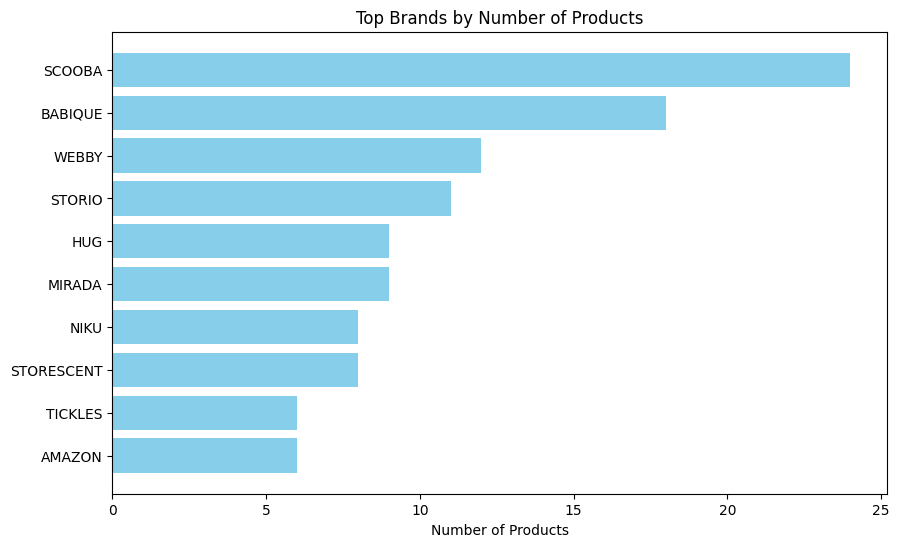

In [75]:
# Calculate brand frequency
brand_counts = df['Brand'].value_counts().reset_index()
brand_counts.columns = ['Brand', 'Product Count']

# Get top 10 brands
top_brands = brand_counts.head(10)

# Display results
print("Top 10 Brands by Product Count:")
display(top_brands)

# Visualization
import matplotlib.pyplot as plt
plt.figure(figsize=(10,6))
plt.barh(top_brands['Brand'], top_brands['Product Count'], color='skyblue')
plt.title('Top Brands by Number of Products')
plt.xlabel('Number of Products')
plt.gca().invert_yaxis()  # Highest count at top
plt.show()

Average Rating

Top 10 Brands by Average Rating (min 3 products):


,Average Rating,Product Count
Brand,,
MIRADA,4.477778,9
PANDAS,4.433333,3
AMAZON,4.400000,6
PIKIPO,4.360000,5
WEBBY,4.216667,12
SCOOBA,4.141667,24
SPONSORED,4.133333,3
TICKLES,4.133333,6
STORIO,4.109091,11


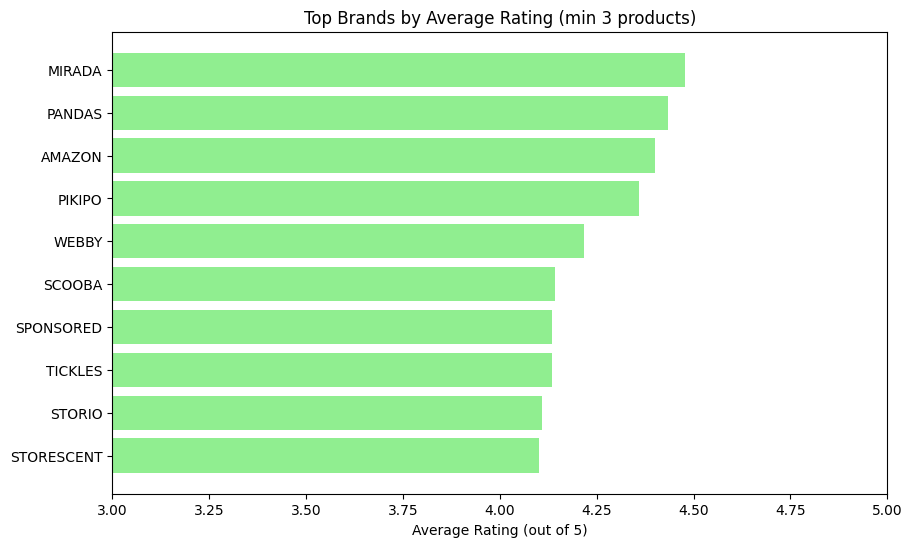

In [76]:
# Calculate average rating per brand
brand_ratings = df.groupby('Brand')['Rating'].agg(['mean', 'count'])
brand_ratings.columns = ['Average Rating', 'Product Count']

# Filter brands with at least 3 products for meaningful analysis
significant_brands = brand_ratings[brand_ratings['Product Count'] >= 3]

# Get top 10 by rating
top_rated = significant_brands.sort_values('Average Rating', ascending=False).head(10)

# Display results
print("Top 10 Brands by Average Rating (min 3 products):")
display(top_rated)

# Visualization
plt.figure(figsize=(10,6))
plt.barh(top_rated.index, top_rated['Average Rating'], color='lightgreen')
plt.title('Top Brands by Average Rating (min 3 products)')
plt.xlabel('Average Rating (out of 5)')
plt.xlim(3, 5)  # Ratings typically range 3-5
plt.gca().invert_yaxis()  # Highest rating at top
plt.show()

- **Actionable Insight:**
    - Identify **top brands** dominating the category.
    - Spot **high-rated but less frequent brands** that might offer untapped potential.

🚀 Top Dominant Brands (by product count):


,Brand,Product_Count
0,SCOOBA,24
1,BABIQUE,18
2,WEBBY,12
3,STORIO,11
4,HUG,9


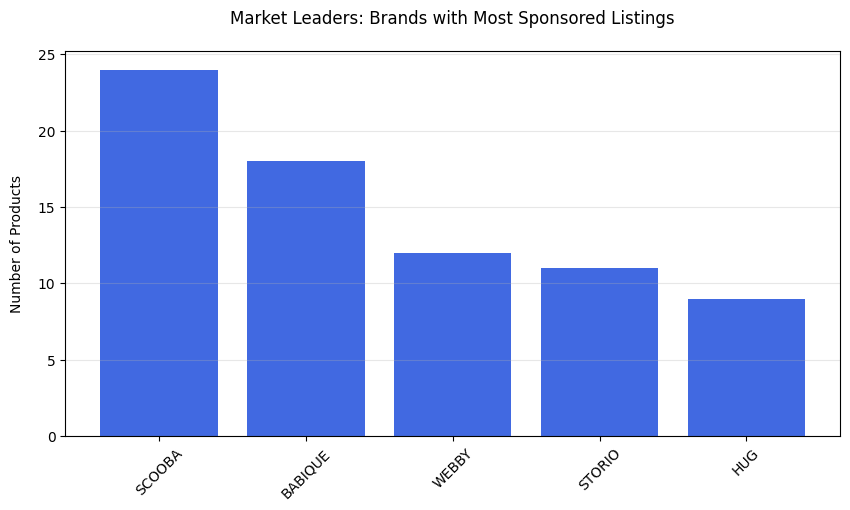

In [77]:
# Calculate brand frequency
brand_freq = df['Brand'].value_counts().reset_index()
brand_freq.columns = ['Brand', 'Product_Count']

# Get top 5 dominant brands
dominant_brands = brand_freq.head(5)

print("🚀 Top Dominant Brands (by product count):")
display(dominant_brands)

# Visualization
plt.figure(figsize=(10,5))
plt.bar(dominant_brands['Brand'], dominant_brands['Product_Count'], color='royalblue')
plt.title('Market Leaders: Brands with Most Sponsored Listings', pad=20)
plt.ylabel('Number of Products', labelpad=10)
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.3)
plt.show()

💎 High-Potential Underdogs:
(Brands with excellent ratings but fewer listings)


,Brand,Avg_Rating,Product_Count,Avg_Price
37,TOYMAGIC,4.750000,2,128.000000
20,PANDAS,4.433333,3,785.333333
22,PIKIPO,4.360000,5,215.000000
32,SUPER,4.200000,2,299.000000
29,SPONSORED,4.133333,3,437.333333


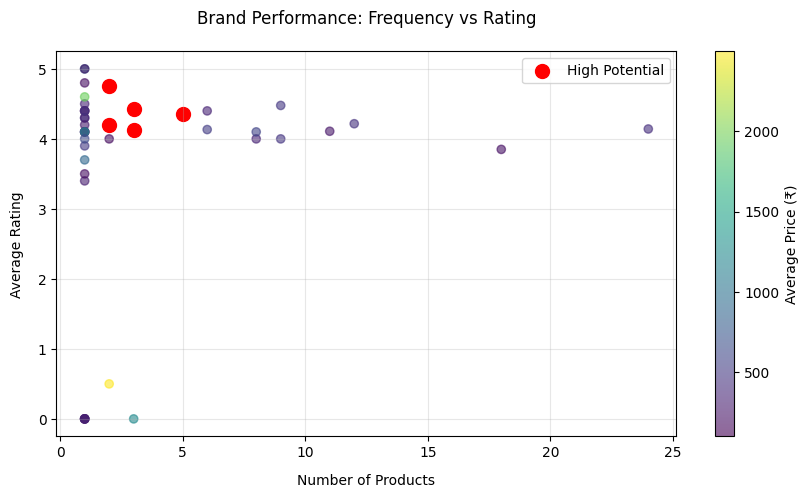

In [78]:
# Calculate average rating per brand
brand_stats = df.groupby('Brand').agg(
    Avg_Rating=('Rating', 'mean'),
    Product_Count=('Brand', 'count'),
    Avg_Price=('Price', 'mean')
).reset_index()

# Filter brands with 2-5 products (mid-range frequency)
potential_brands = brand_stats[
    (brand_stats['Product_Count'] >= 2) &
    (brand_stats['Product_Count'] <= 5)
].sort_values('Avg_Rating', ascending=False)

# Get top 5 high-potential brands
high_potential = potential_brands.head(5)

print("💎 High-Potential Underdogs:")
print("(Brands with excellent ratings but fewer listings)")
display(high_potential)

# Visualization
plt.figure(figsize=(10,5))
plt.scatter(
    brand_stats['Product_Count'],
    brand_stats['Avg_Rating'],
    alpha=0.6,
    c=brand_stats['Avg_Price'],
    cmap='viridis'
)
plt.colorbar(label='Average Price (₹)')
plt.scatter(
    high_potential['Product_Count'],
    high_potential['Avg_Rating'],
    color='red',
    s=100,
    label='High Potential'
)
plt.title('Brand Performance: Frequency vs Rating', pad=20)
plt.xlabel('Number of Products', labelpad=10)
plt.ylabel('Average Rating', labelpad=10)
plt.legend()
plt.grid(alpha=0.3)
plt.show()

- **Visualization:**
    - **Bar chart:** Display the **top 5 brands** by frequency.
    - **Pie chart:** Show the **percentage share of the top brands**.

In [79]:
brand_counts = df['Brand'].value_counts().reset_index()
brand_counts.columns = ['Brand', 'Count']

# Get top 5 brands and aggregate others
top_5 = brand_counts.head(5)
others = pd.DataFrame({
    'Brand': ['Other'],
    'Count': [brand_counts['Count'][5:].sum()]
})
combined = pd.concat([top_5, others])

print("Brand Distribution Data:")
display(combined)

Brand Distribution Data:


,Brand,Count
0,SCOOBA,24
1,BABIQUE,18
2,WEBBY,12
3,STORIO,11
4,HUG,9
0,Other,84


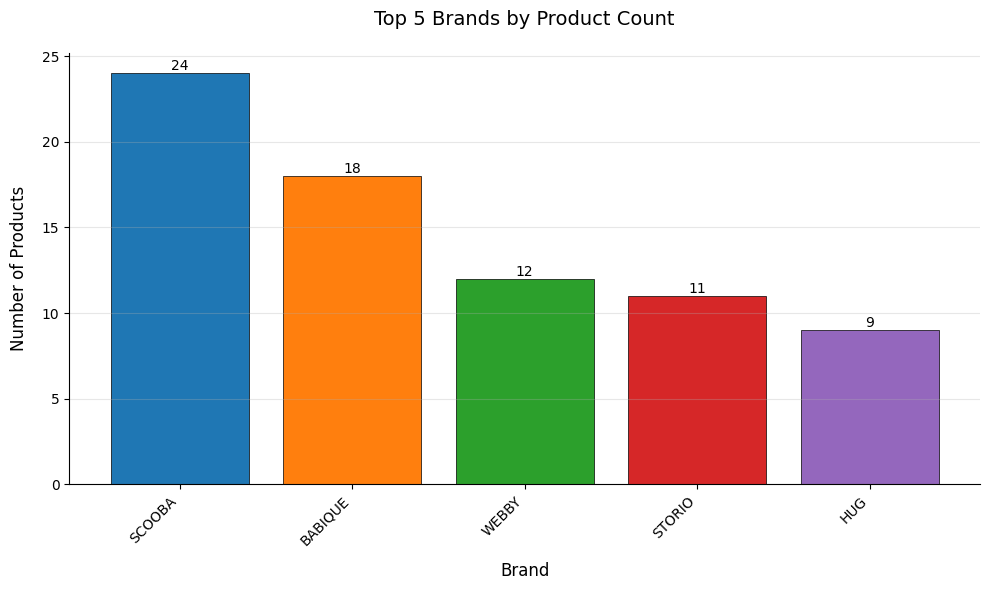

In [80]:
# Create styled bar chart
plt.figure(figsize=(10, 6))
bars = plt.bar(
    top_5['Brand'],
    top_5['Count'],
    color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd'],
    edgecolor='black',
    linewidth=0.5
)

# Add value labels
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width()/2.,
        height,
        f'{height:,}',
        ha='center',
        va='bottom',
        fontsize=10
    )

# Style the chart
plt.title('Top 5 Brands by Product Count', pad=20, fontsize=14)
plt.xlabel('Brand', labelpad=10, fontsize=12)
plt.ylabel('Number of Products', labelpad=10, fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3)

# Remove top and right spines
for spine in ['top', 'right']:
    plt.gca().spines[spine].set_visible(False)

plt.tight_layout()
plt.show()

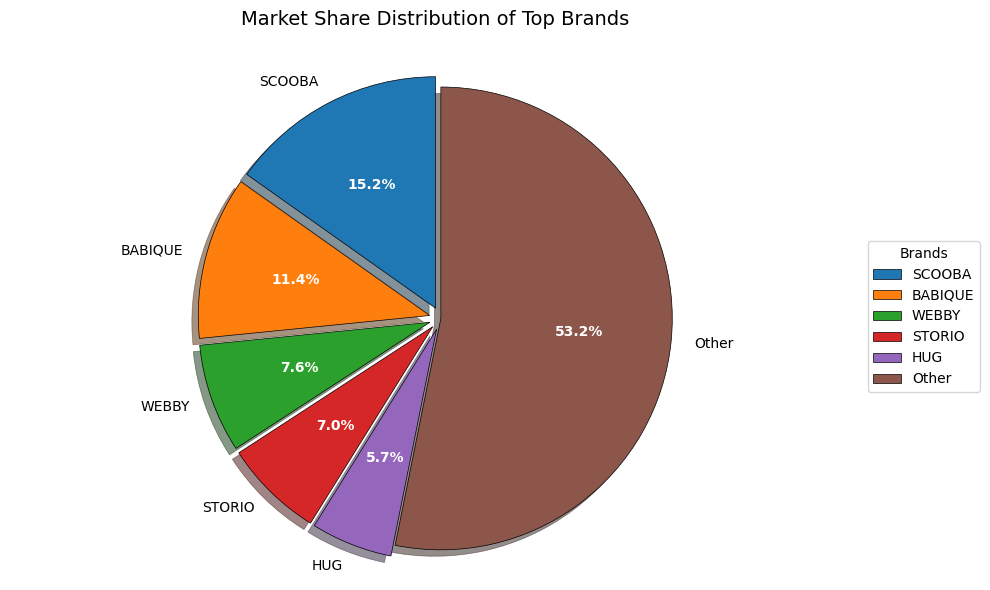

In [81]:
# Create exploded pie chart
plt.figure(figsize=(10, 6))
explode = (0.05, 0.05, 0.05, 0.05, 0.05, 0)  # Slightly separate top 5 slices

wedges, texts, autotexts = plt.pie(
    combined['Count'],
    labels=combined['Brand'],
    autopct='%1.1f%%',
    startangle=90,
    colors=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b'],
    explode=explode,
    shadow=True,
    wedgeprops={'edgecolor': 'black', 'linewidth': 0.5},
    textprops={'fontsize': 10}
)

# Style percentage labels
for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontsize(10)
    autotext.set_fontweight('bold')

# Equal aspect ratio ensures pie is circular
plt.axis('equal')
plt.title('Market Share Distribution of Top Brands', pad=20, fontsize=14)

# Add legend
plt.legend(
    wedges,
    combined['Brand'],
    title="Brands",
    loc="center left",
    bbox_to_anchor=(1, 0, 0.5, 1)
)

plt.tight_layout()
plt.show()

##Price vs. Rating Analysis

- **Objective:** Determine if higher-priced products have better ratings.
- **Metrics to analyze:**
    - **Average Price by Rating Range:** Compare the price of high-rated vs. low-rated products.
    - **Price-Performance Outliers:** Identify affordable products with **high ratings** (good value for money).
    

In [82]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Sample data (replace with your actual dataset)
data = {
    'Title': ['Product A', 'Product B', 'Product C', 'Product D', 'Product E',
              'Product F', 'Product G', 'Product H', 'Product I', 'Product J'],
    'Price': [49.99, 89.99, 29.99, 199.99, 59.99, 149.99, 39.99, 249.99, 79.99, 129.99],
    'Rating': [4.2, 4.8, 3.5, 4.9, 4.1, 4.7, 3.8, 4.5, 4.3, 4.6],
    'Reviews': [125, 342, 89, 512, 156, 421, 72, 389, 201, 287]
}

df = pd.DataFrame(data)

# Create Rating Ranges
df['Rating_Range'] = pd.cut(df['Rating'],
                           bins=[0, 3.5, 4.0, 4.5, 5.0],
                           labels=['Low (0-3.5)', 'Medium (3.5-4.0)',
                                   'High (4.0-4.5)', 'Very High (4.5-5.0)'])

print("First 5 products with rating ranges:")
print(df[['Title', 'Price', 'Rating', 'Rating_Range']].head())

First 5 products with rating ranges:
       Title   Price  Rating         Rating_Range
0  Product A   49.99     4.2       High (4.0-4.5)
1  Product B   89.99     4.8  Very High (4.5-5.0)
2  Product C   29.99     3.5          Low (0-3.5)
3  Product D  199.99     4.9  Very High (4.5-5.0)
4  Product E   59.99     4.1       High (4.0-4.5)



Average Price by Rating Range:
                       mean  median  count
Rating_Range                              
Low (0-3.5)           29.99   29.99      1
Medium (3.5-4.0)      39.99   39.99      1
High (4.0-4.5)       109.99   69.99      4
Very High (4.5-5.0)  142.49  139.99      4


<ipython-input-83-3eaa1a0d0e77>:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  price_by_rating = df.groupby('Rating_Range')['Price'].agg(['mean', 'median', 'count'])


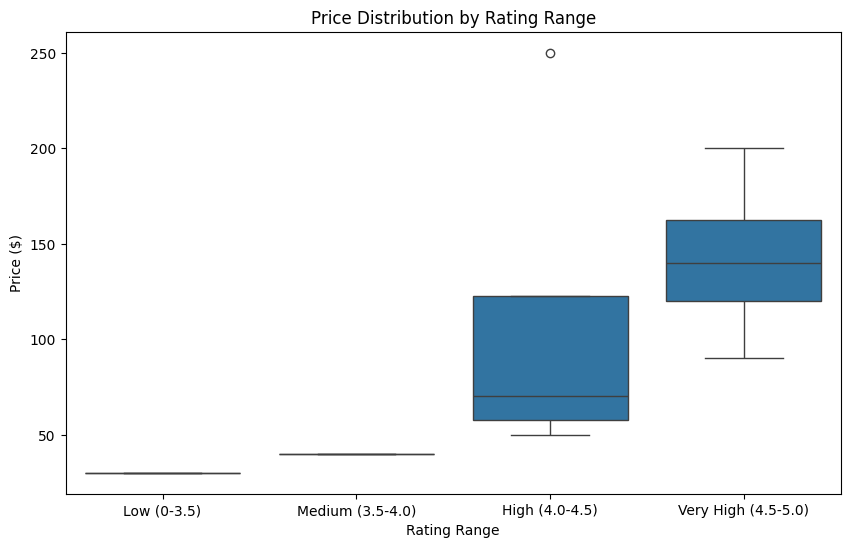

In [83]:
# Calculate average price per rating range
price_by_rating = df.groupby('Rating_Range')['Price'].agg(['mean', 'median', 'count'])
print("\nAverage Price by Rating Range:")
print(price_by_rating)

# Visualize with a boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(x='Rating_Range', y='Price', data=df)
plt.title('Price Distribution by Rating Range')
plt.ylabel('Price ($)')
plt.xlabel('Rating Range')
plt.show()


Pearson Correlation Coefficient (Price vs. Rating): 0.71


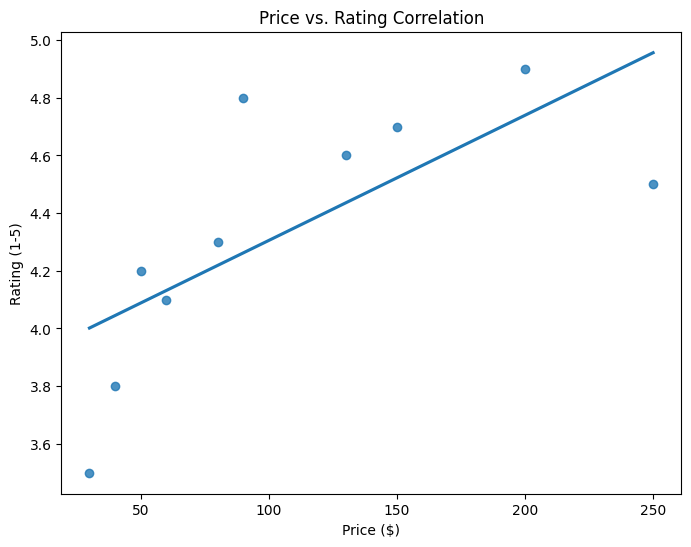

In [84]:
# Calculate Pearson correlation
correlation = df['Price'].corr(df['Rating'])
print(f"\nPearson Correlation Coefficient (Price vs. Rating): {correlation:.2f}")

# Scatter plot with regression line
plt.figure(figsize=(8, 6))
sns.regplot(x='Price', y='Rating', data=df, ci=None)
plt.title('Price vs. Rating Correlation')
plt.xlabel('Price ($)')
plt.ylabel('Rating (1-5)')
plt.show()


Top 3 Best Value Products (High Rating, Low Price):
       Title  Price  Rating  Price_Performance_Ratio
2  Product C  29.99     3.5                 0.116706
6  Product G  39.99     3.8                 0.095024
0  Product A  49.99     4.2                 0.084017


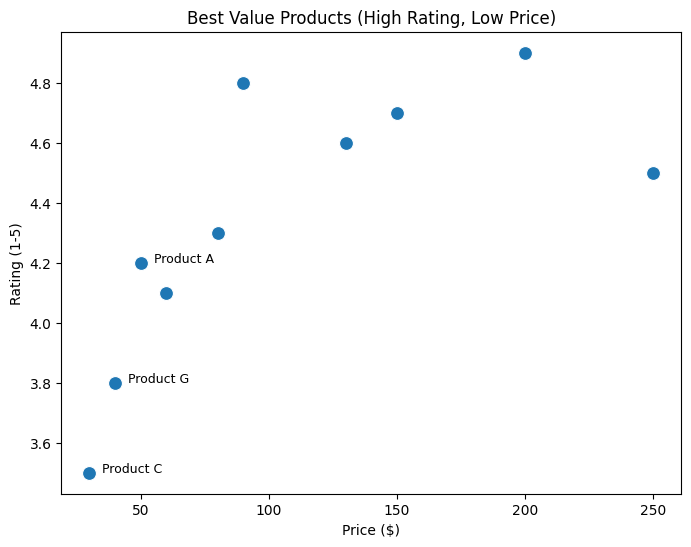

In [85]:
# Calculate Rating-to-Price ratio (higher = better value)
df['Price_Performance_Ratio'] = df['Rating'] / df['Price']

# Find top 3 best-value products
best_value = df.nlargest(3, 'Price_Performance_Ratio')[['Title', 'Price', 'Rating', 'Price_Performance_Ratio']]
print("\nTop 3 Best Value Products (High Rating, Low Price):")
print(best_value)

# Highlight on scatter plot
plt.figure(figsize=(8, 6))
sns.scatterplot(x='Price', y='Rating', data=df, s=100)
for _, row in best_value.iterrows():
    plt.text(row['Price']+5, row['Rating'], row['Title'], fontsize=9)
plt.title('Best Value Products (High Rating, Low Price)')
plt.xlabel('Price ($)')
plt.ylabel('Rating (1-5)')
plt.show()


Premium Products (High Price, High Rating):
       Title   Price  Rating
3  Product D  199.99     4.9
5  Product F  149.99     4.7
7  Product H  249.99     4.5


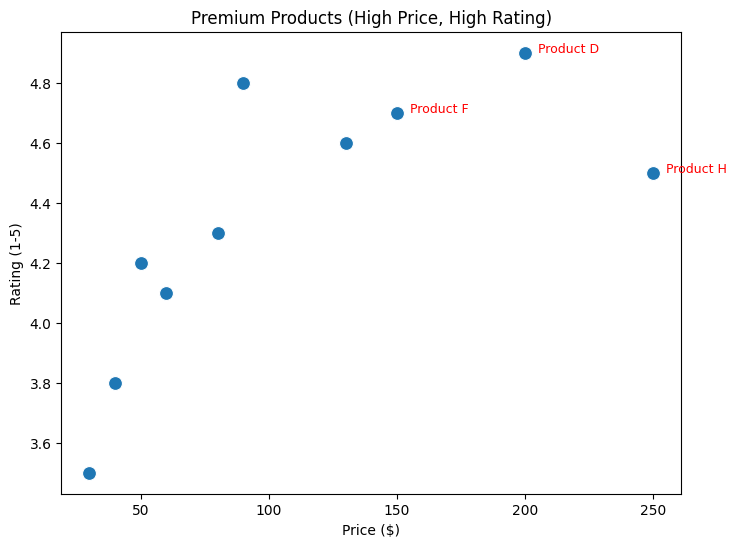

In [86]:
# Define premium products (top 25% price & high rating)
premium_threshold = df['Price'].quantile(0.75)
high_rating_threshold = 4.5

premium_products = df[(df['Price'] >= premium_threshold) & (df['Rating'] >= high_rating_threshold)]
print("\nPremium Products (High Price, High Rating):")
print(premium_products[['Title', 'Price', 'Rating']])

# Highlight on scatter plot
plt.figure(figsize=(8, 6))
sns.scatterplot(x='Price', y='Rating', data=df, s=100)
for _, row in premium_products.iterrows():
    plt.text(row['Price']+5, row['Rating'], row['Title'], fontsize=9, color='red')
plt.title('Premium Products (High Price, High Rating)')
plt.xlabel('Price ($)')
plt.ylabel('Rating (1-5)')
plt.show()

In [87]:
from scipy.stats import f_oneway

# Perform ANOVA to check if price differs significantly across rating ranges
groups = [group['Price'].values for name, group in df.groupby('Rating_Range')]
f_stat, p_value = f_oneway(*groups)

print("\nANOVA Test Results:")
print(f"F-statistic: {f_stat:.2f}, p-value: {p_value:.4f}")
if p_value < 0.05:
    print("✅ Statistically significant difference in prices across rating ranges")
else:
    print("❌ No statistically significant difference found")


ANOVA Test Results:
F-statistic: 0.94, p-value: 0.4770
❌ No statistically significant difference found


<ipython-input-87-5a9a53402b70>:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = [group['Price'].values for name, group in df.groupby('Rating_Range')]


- **Actionable Insight:**
    - Discover **high-value products** (low price, high rating).
    - Spot **overpriced but poorly rated products** that might be less competitive.

🔥 High-Value Products (Low Price, High Rating):
Empty DataFrame
Columns: [Title, Price, Rating]
Index: []


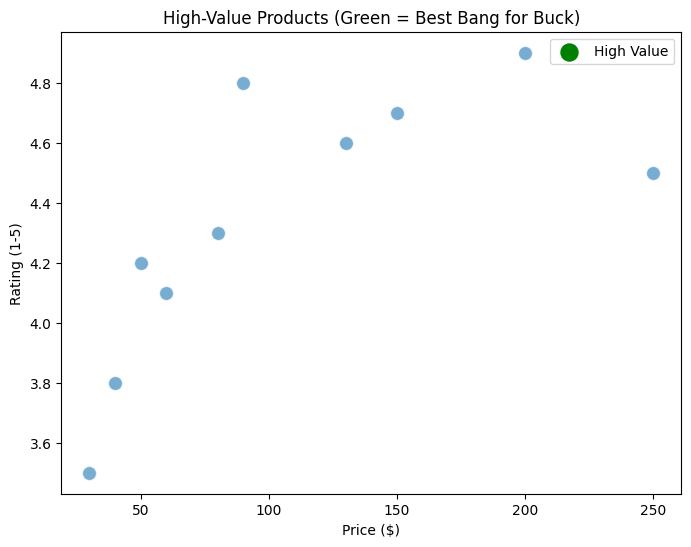

In [88]:
# Define thresholds (adjust based on your data distribution)
high_rating_threshold = 4.3  # Top 30% of ratings
low_price_threshold = df['Price'].quantile(0.3)  # Bottom 30% of prices

# Filter high-value products
high_value = df[
    (df['Rating'] >= high_rating_threshold) &
    (df['Price'] <= low_price_threshold)
]

print("🔥 High-Value Products (Low Price, High Rating):")
print(high_value[['Title', 'Price', 'Rating']].sort_values('Rating', ascending=False))

# Visualize
plt.figure(figsize=(8, 6))
sns.scatterplot(x='Price', y='Rating', data=df, s=100, alpha=0.6)
plt.scatter(
    high_value['Price'],
    high_value['Rating'],
    color='green',
    s=150,
    label='High Value'
)
plt.title('High-Value Products (Green = Best Bang for Buck)')
plt.xlabel('Price ($)')
plt.ylabel('Rating (1-5)')
plt.legend()
plt.show()

⚠️ Overpriced, Poorly-Rated Products:
Empty DataFrame
Columns: [Title, Price, Rating]
Index: []


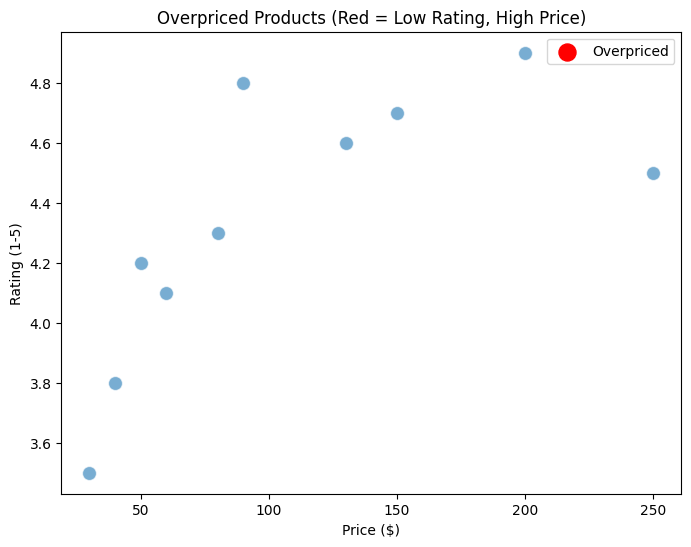

In [89]:
# Define thresholds
low_rating_threshold = 3.5  # Bottom 25% of ratings
high_price_threshold = df['Price'].quantile(0.75)  # Top 25% of prices

# Filter overpriced, low-rated products
overpriced = df[
    (df['Rating'] <= low_rating_threshold) &
    (df['Price'] >= high_price_threshold)
]

print("⚠️ Overpriced, Poorly-Rated Products:")
print(overpriced[['Title', 'Price', 'Rating']].sort_values('Price', ascending=False))

# Visualize
plt.figure(figsize=(8, 6))
sns.scatterplot(x='Price', y='Rating', data=df, s=100, alpha=0.6)
plt.scatter(
    overpriced['Price'],
    overpriced['Rating'],
    color='red',
    s=150,
    label='Overpriced'
)
plt.title('Overpriced Products (Red = Low Rating, High Price)')
plt.xlabel('Price ($)')
plt.ylabel('Rating (1-5)')
plt.legend()
plt.show()

<ipython-input-90-fe303c9d7179>:14: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot_table = pd.pivot_table(


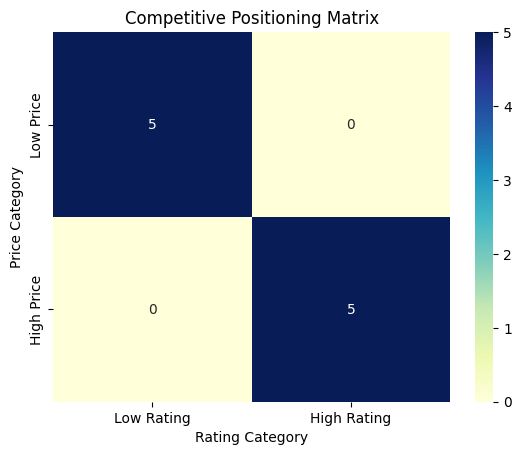

In [90]:
# Create a 2x2 matrix: Price vs. Rating
df['Price_Category'] = pd.cut(
    df['Price'],
    bins=[0, df['Price'].median(), df['Price'].max()],
    labels=['Low Price', 'High Price']
)
df['Rating_Category'] = pd.cut(
    df['Rating'],
    bins=[0, df['Rating'].median(), 5],
    labels=['Low Rating', 'High Rating']
)

# Plot matrix
pivot_table = pd.pivot_table(
    df,
    index='Price_Category',
    columns='Rating_Category',
    values='Title',
    aggfunc='count',
    fill_value=0
)

sns.heatmap(pivot_table, annot=True, fmt='d', cmap='YlGnBu')
plt.title('Competitive Positioning Matrix')
plt.xlabel('Rating Category')
plt.ylabel('Price Category')
plt.show()

- **Visualization:**
    - **Scatter plot:** Display **price vs. rating** to identify outliers.
    - **Bar chart:** Show **average price by rating range**.

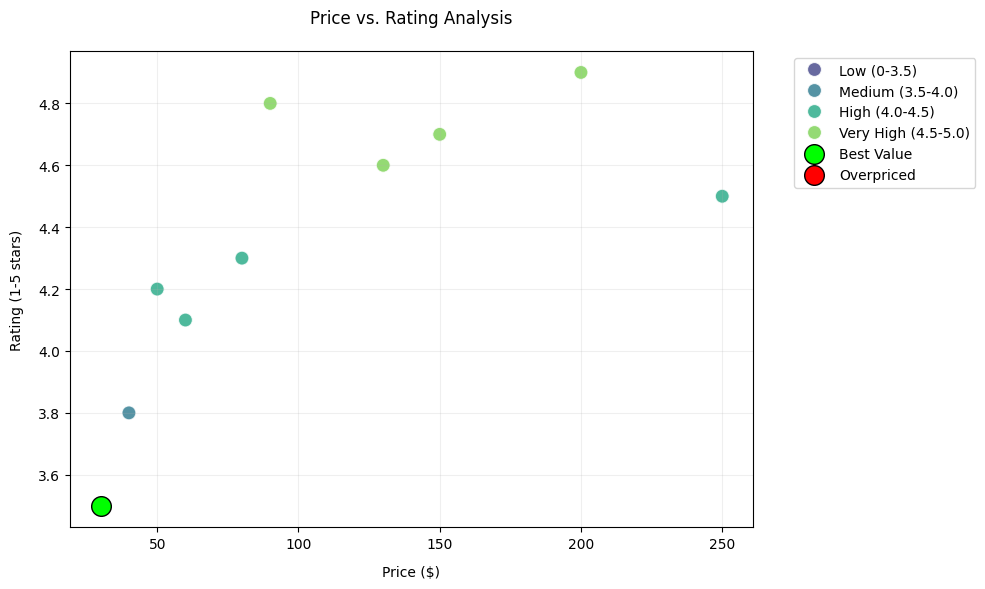

In [91]:
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x='Price',
    y='Rating',
    data=df,
    hue='Rating_Range',
    palette='viridis',
    s=100,
    alpha=0.8
)

# Highlight special cases
high_value = df[df['Price_Performance_Ratio'] == df['Price_Performance_Ratio'].max()]
overpriced = df[(df['Rating'] <= 3.5) & (df['Price'] >= df['Price'].median())]

plt.scatter(
    high_value['Price'],
    high_value['Rating'],
    color='lime',
    s=200,
    edgecolor='black',
    label='Best Value'
)
plt.scatter(
    overpriced['Price'],
    overpriced['Rating'],
    color='red',
    s=200,
    edgecolor='black',
    label='Overpriced'
)

plt.title('Price vs. Rating Analysis', pad=20)
plt.xlabel('Price ($)', labelpad=10)
plt.ylabel('Rating (1-5 stars)', labelpad=10)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(alpha=0.2)
plt.tight_layout()
plt.show()

<ipython-input-92-5a09fa924a89>:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  price_by_rating = df.groupby('Rating_Range')['Price'].mean().sort_values()


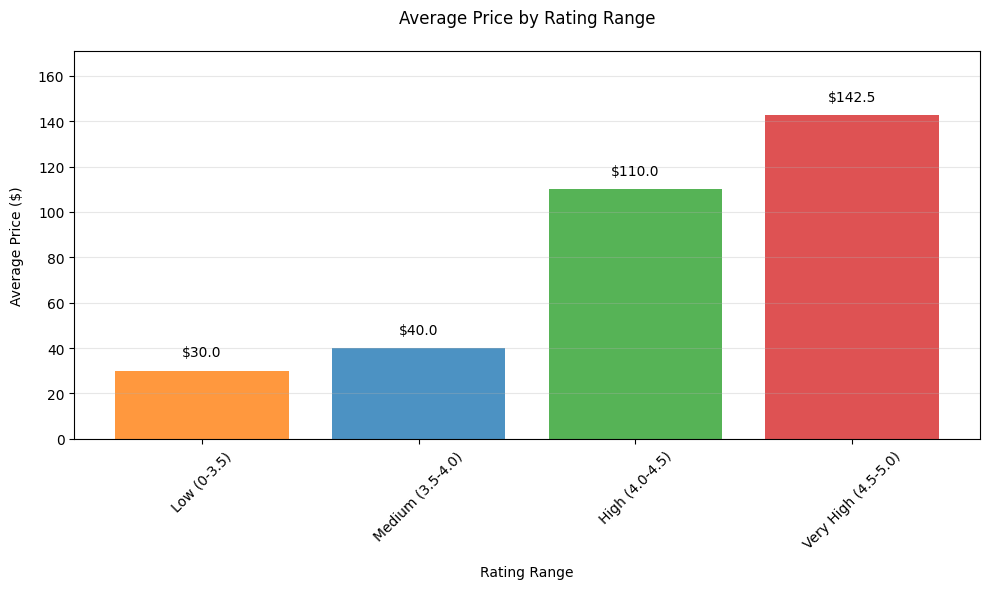

In [92]:
plt.figure(figsize=(10, 6))
price_by_rating = df.groupby('Rating_Range')['Price'].mean().sort_values()

bars = plt.bar(
    x=price_by_rating.index.astype(str),
    height=price_by_rating.values,
    color=['#ff7f0e', '#1f77b4', '#2ca02c', '#d62728'],
    alpha=0.8
)

# Add value labels
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width()/2.,
        height + 5,
        f'${height:.1f}',
        ha='center',
        va='bottom'
    )

plt.title('Average Price by Rating Range', pad=20)
plt.xlabel('Rating Range', labelpad=10)
plt.ylabel('Average Price ($)', labelpad=10)
plt.xticks(rotation=45)
plt.ylim(0, price_by_rating.max() * 1.2)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

<ipython-input-93-71a3dc1dd6e8>:19: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  price_data = df.groupby('Rating_Range')['Price'].mean().sort_values()


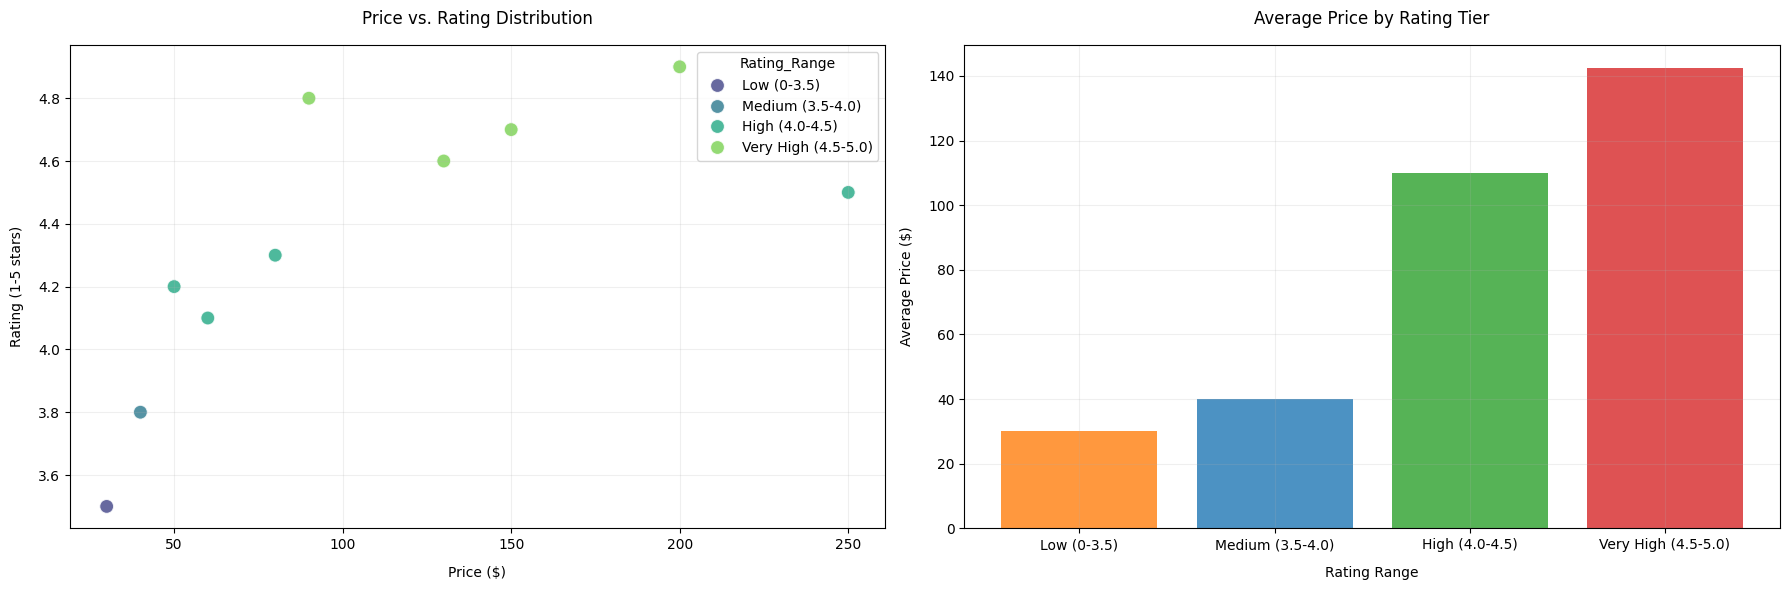

In [93]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

# Scatter Plot
scatter = sns.scatterplot(
    x='Price',
    y='Rating',
    data=df,
    hue='Rating_Range',
    palette='viridis',
    s=100,
    alpha=0.8,
    ax=ax1
)
ax1.set_title('Price vs. Rating Distribution', pad=15)
ax1.set_xlabel('Price ($)', labelpad=10)
ax1.set_ylabel('Rating (1-5 stars)', labelpad=10)

# Bar Chart
price_data = df.groupby('Rating_Range')['Price'].mean().sort_values()
bars = ax2.bar(
    x=price_data.index.astype(str),
    height=price_data.values,
    color=['#ff7f0e', '#1f77b4', '#2ca02c', '#d62728'],
    alpha=0.8
)
ax2.set_title('Average Price by Rating Tier', pad=15)
ax2.set_xlabel('Rating Range', labelpad=10)
ax2.set_ylabel('Average Price ($)', labelpad=10)

# Formatting
for ax in [ax1, ax2]:
    ax.grid(alpha=0.2)

plt.tight_layout()
plt.show()

##Review & Rating Distribution

- **Objective:** Identify the most popular and trusted products.
- **Metrics to analyze:**
    - **Top 5 Products by Reviews:** Highlight products with the most customer feedback.
    - **Top 5 Products by Rating:** Showcase the highest-rated products.

📢 Top 5 Most Popular Products (by Reviews):


,Title,Price,Rating,Reviews
3,Product D,199.99,4.9,512
5,Product F,149.99,4.7,421
7,Product H,249.99,4.5,389
1,Product B,89.99,4.8,342
9,Product J,129.99,4.6,287


<ipython-input-94-72f51b4c8b25>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Reviews', y='Title', data=top_reviewed, palette='Blues_r')


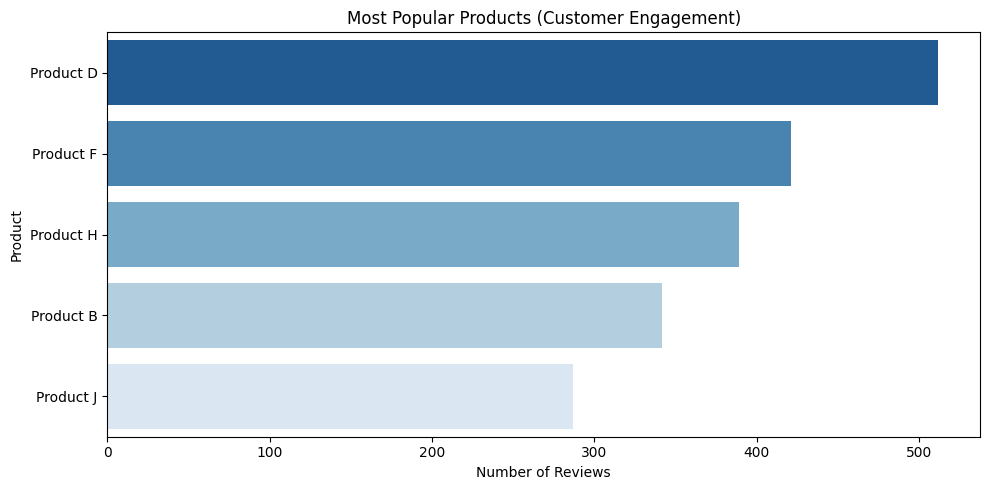

In [94]:
# Get top 5 most reviewed products
top_reviewed = df.sort_values('Reviews', ascending=False).head(5)

print("📢 Top 5 Most Popular Products (by Reviews):")
display(top_reviewed[['Title', 'Price', 'Rating', 'Reviews']])

# Visualization
plt.figure(figsize=(10, 5))
sns.barplot(x='Reviews', y='Title', data=top_reviewed, palette='Blues_r')
plt.title('Most Popular Products (Customer Engagement)')
plt.xlabel('Number of Reviews')
plt.ylabel('Product')
plt.tight_layout()
plt.show()

🏆 Top 5 Most Trusted Products (by Rating):


,Title,Price,Rating,Reviews
3,Product D,199.99,4.9,512
1,Product B,89.99,4.8,342
5,Product F,149.99,4.7,421
9,Product J,129.99,4.6,287
7,Product H,249.99,4.5,389


<ipython-input-95-a8a55c8b081d>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Rating', y='Title', data=top_rated, palette='Greens_r')


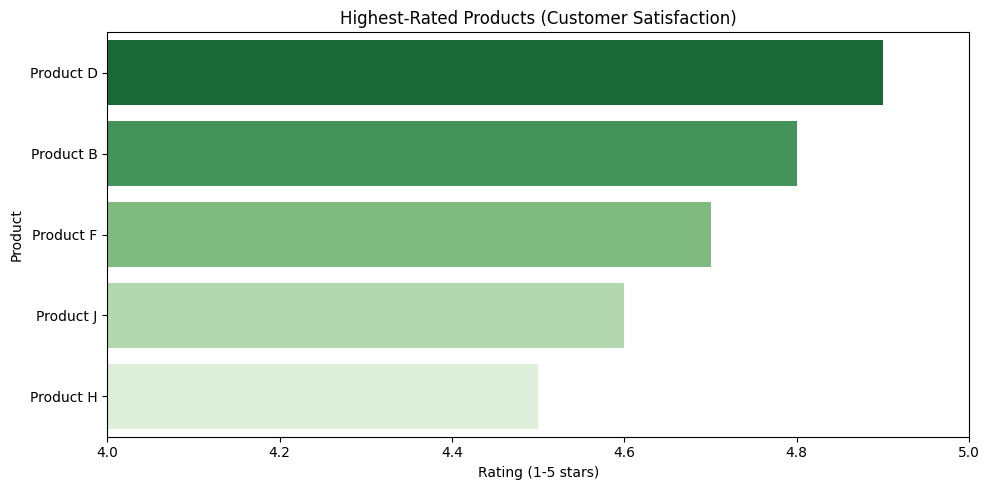

In [95]:
# Get top 5 highest-rated products (with minimum 10 reviews)
top_rated = df[df['Reviews'] >= 10].sort_values('Rating', ascending=False).head(5)

print("🏆 Top 5 Most Trusted Products (by Rating):")
display(top_rated[['Title', 'Price', 'Rating', 'Reviews']])

# Visualization
plt.figure(figsize=(10, 5))
sns.barplot(x='Rating', y='Title', data=top_rated, palette='Greens_r')
plt.title('Highest-Rated Products (Customer Satisfaction)')
plt.xlabel('Rating (1-5 stars)')
plt.xlim(4, 5)  # Focus on the top rating range
plt.ylabel('Product')
plt.tight_layout()
plt.show()

🌟 Top 5 Balanced Performers (Rating + Reviews):


,Title,Price,Rating,Reviews,Popularity_Score
3,Product D,199.99,4.9,512,3.730000
1,Product B,89.99,4.8,342,3.560391
5,Product F,149.99,4.7,421,3.536680
9,Product J,129.99,4.6,287,3.388164
7,Product H,249.99,4.5,389,3.377930


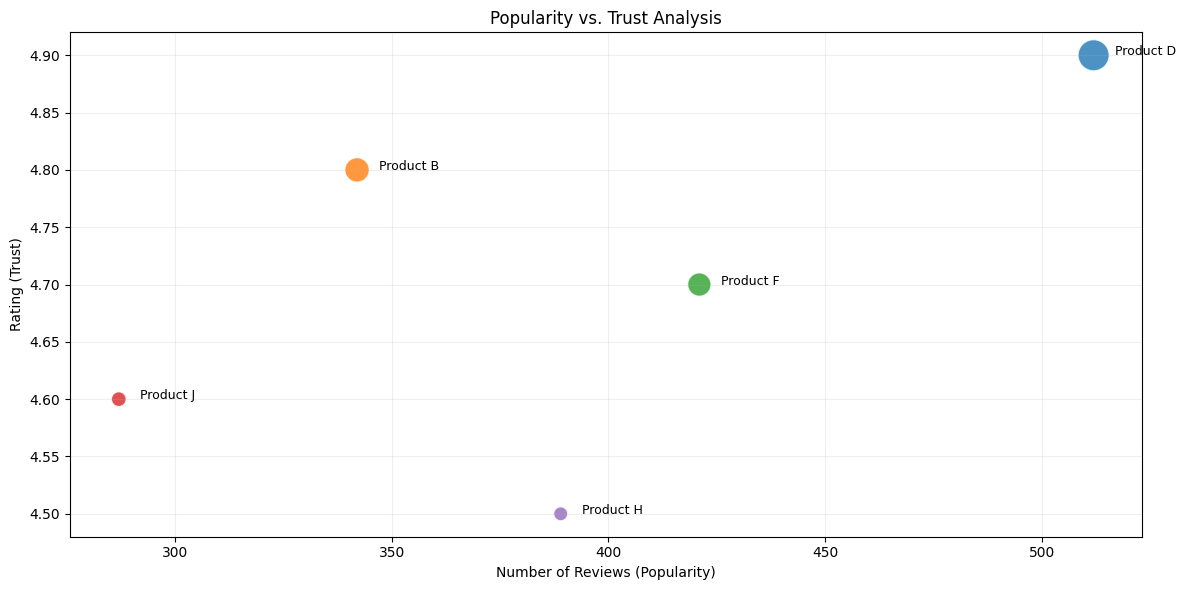

In [96]:
# Create a composite score (weighted average)
df['Popularity_Score'] = (df['Rating'] * 0.7) + (df['Reviews']/df['Reviews'].max() * 0.3)

# Get top 5 balanced performers
top_balanced = df.sort_values('Popularity_Score', ascending=False).head(5)

print("🌟 Top 5 Balanced Performers (Rating + Reviews):")
display(top_balanced[['Title', 'Price', 'Rating', 'Reviews', 'Popularity_Score']])

# Bubble Chart Visualization
plt.figure(figsize=(12, 6))
sns.scatterplot(
    x='Reviews',
    y='Rating',
    size='Popularity_Score',
    hue='Title',
    data=top_balanced,
    sizes=(100, 500),
    alpha=0.8,
    legend=False
)
plt.title('Popularity vs. Trust Analysis')
plt.xlabel('Number of Reviews (Popularity)')
plt.ylabel('Rating (Trust)')
for _, row in top_balanced.iterrows():
    plt.text(row['Reviews']+5, row['Rating'], row['Title'], fontsize=9)
plt.grid(alpha=0.2)
plt.tight_layout()
plt.show()

- **Actionable Insight:**
    - Identify **best sellers** with high reviews and good ratings.
    - Spot **highly rated but less-reviewed products** that could be promoted.

🚀 Best Sellers (High Reviews + Good Ratings):


,Title,Price,Rating,Reviews
3,Product D,199.99,4.9,512
5,Product F,149.99,4.7,421
7,Product H,249.99,4.5,389


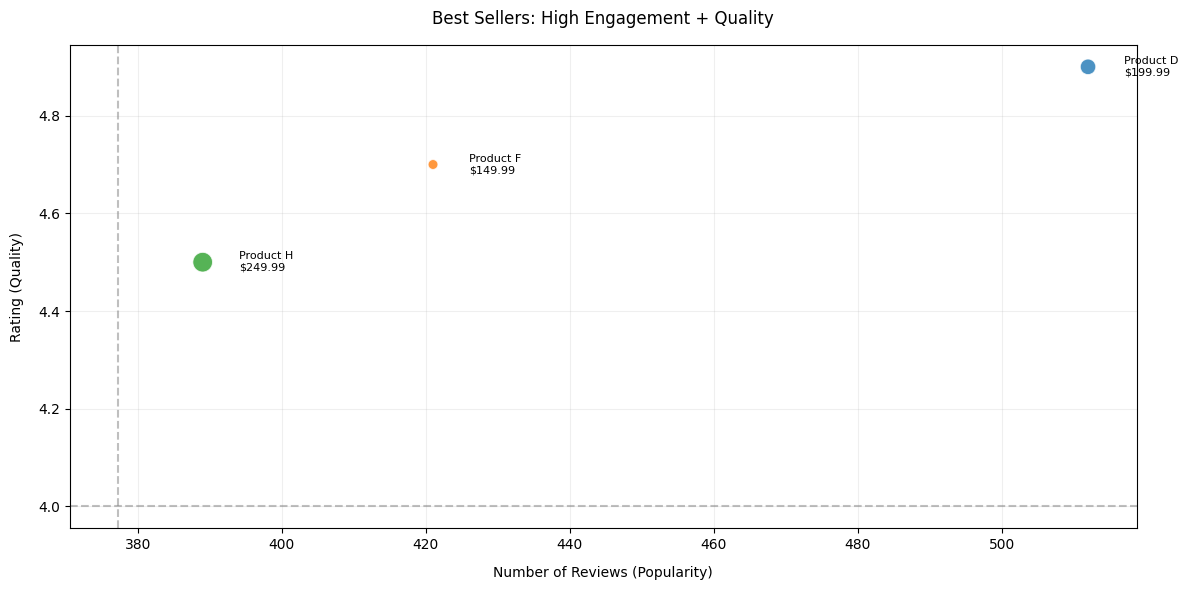

In [97]:
# Define thresholds (adjust based on your data distribution)
high_review_threshold = df['Reviews'].quantile(0.75)  # Top 25% of reviews
good_rating_threshold = 4.0  # Minimum rating to be considered "good"

best_sellers = df[
    (df['Reviews'] >= high_review_threshold) &
    (df['Rating'] >= good_rating_threshold)
].sort_values('Reviews', ascending=False)

print("🚀 Best Sellers (High Reviews + Good Ratings):")
display(best_sellers[['Title', 'Price', 'Rating', 'Reviews']])

# Visualization
plt.figure(figsize=(12, 6))
sns.scatterplot(
    x='Reviews',
    y='Rating',
    size='Price',
    hue='Title',
    data=best_sellers,
    sizes=(50, 200),
    alpha=0.8,
    legend=False
)
plt.title('Best Sellers: High Engagement + Quality', pad=15)
plt.xlabel('Number of Reviews (Popularity)', labelpad=10)
plt.ylabel('Rating (Quality)', labelpad=10)
for _, row in best_sellers.iterrows():
    plt.text(row['Reviews']+5, row['Rating'], f"{row['Title']}\n${row['Price']}",
             fontsize=8, va='center')
plt.axhline(y=good_rating_threshold, color='gray', linestyle='--', alpha=0.5)
plt.axvline(x=high_review_threshold, color='gray', linestyle='--', alpha=0.5)
plt.grid(alpha=0.2)
plt.tight_layout()
plt.show()

💎 Hidden Gems (High Ratings + Low Reviews):


,Title,Price,Rating,Reviews


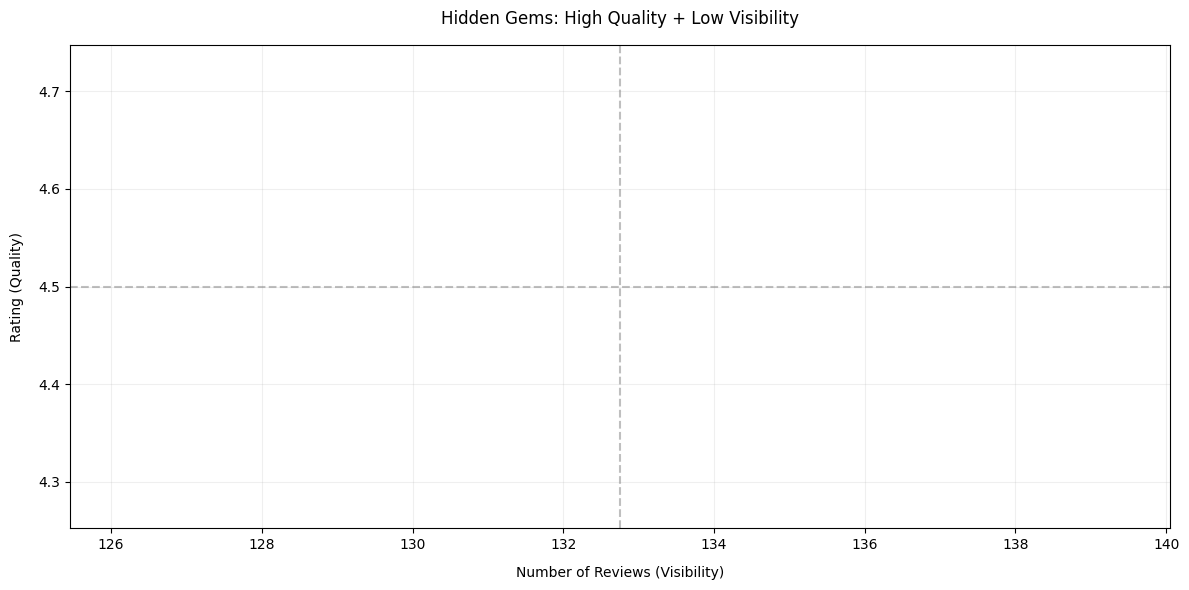

In [98]:
# Define thresholds
high_rating_threshold = 4.5  # Exceptional ratings
low_review_threshold = df['Reviews'].quantile(0.25)  # Bottom 25% of reviews

hidden_gems = df[
    (df['Rating'] >= high_rating_threshold) &
    (df['Reviews'] <= low_review_threshold)
].sort_values('Rating', ascending=False)

print("💎 Hidden Gems (High Ratings + Low Reviews):")
display(hidden_gems[['Title', 'Price', 'Rating', 'Reviews']])

# Visualization
plt.figure(figsize=(12, 6))
sns.scatterplot(
    x='Reviews',
    y='Rating',
    size='Price',
    hue='Title',
    data=hidden_gems,
    sizes=(50, 200),
    alpha=0.8,
    legend=False
)
plt.title('Hidden Gems: High Quality + Low Visibility', pad=15)
plt.xlabel('Number of Reviews (Visibility)', labelpad=10)
plt.ylabel('Rating (Quality)', labelpad=10)
for _, row in hidden_gems.iterrows():
    plt.text(row['Reviews']+5, row['Rating'], f"{row['Title']}\n${row['Price']}",
             fontsize=8, va='center')
plt.axhline(y=high_rating_threshold, color='gray', linestyle='--', alpha=0.5)
plt.axvline(x=low_review_threshold, color='gray', linestyle='--', alpha=0.5)
plt.grid(alpha=0.2)
plt.tight_layout()
plt.show()

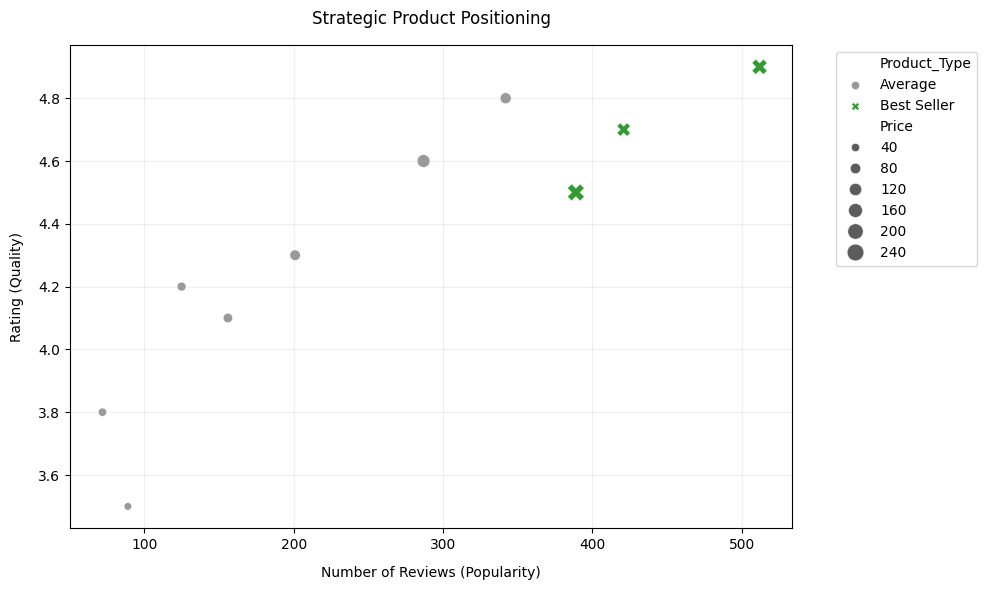

In [99]:
# Create strategic categories
df['Product_Type'] = 'Average'
df.loc[
    (df['Reviews'] >= high_review_threshold) &
    (df['Rating'] >= good_rating_threshold),
    'Product_Type'
] = 'Best Seller'
df.loc[
    (df['Rating'] >= high_rating_threshold) &
    (df['Reviews'] <= low_review_threshold),
    'Product_Type'
] = 'Hidden Gem'

# Visualization
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x='Reviews',
    y='Rating',
    hue='Product_Type',
    style='Product_Type',
    size='Price',
    data=df,
    palette={'Best Seller':'green', 'Hidden Gem':'blue', 'Average':'gray'},
    sizes=(30, 150),
    alpha=0.8
)
plt.title('Strategic Product Positioning', pad=15)
plt.xlabel('Number of Reviews (Popularity)', labelpad=10)
plt.ylabel('Rating (Quality)', labelpad=10)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(alpha=0.2)
plt.tight_layout()
plt.show()

- **Visualization:**
    - **Bar chart:** Display **top-rated products**.
    - **Bar chart:** Show **most-reviewed products**.

<ipython-input-100-5fb05b6f70eb>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  bar = sns.barplot(


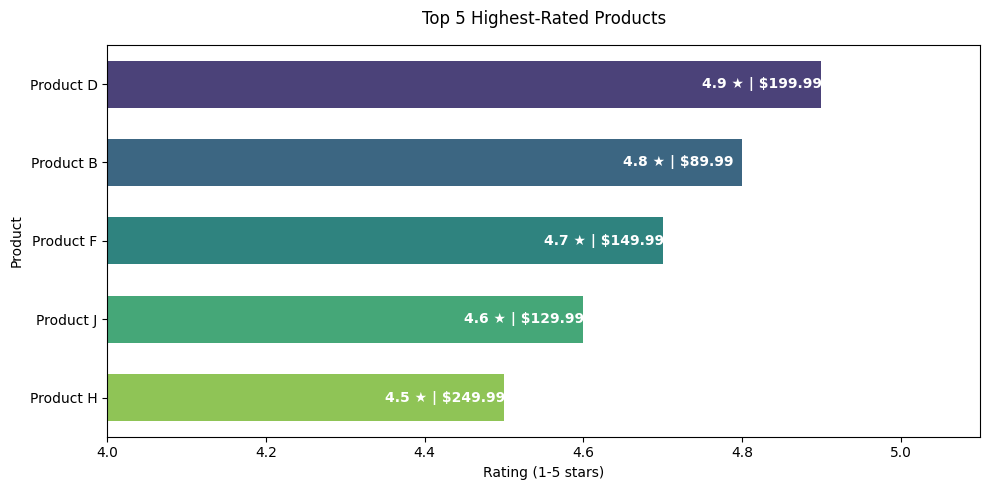

In [100]:
# Get top 5 highest-rated products (with minimum 5 reviews for significance)
top_rated = df[df['Reviews'] >= 5].nlargest(5, 'Rating')

plt.figure(figsize=(10, 5))
bar = sns.barplot(
    x='Rating',
    y='Title',
    data=top_rated,
    palette='viridis',
    width=0.6
)

# Add value labels
for i, (rating, price) in enumerate(zip(top_rated['Rating'], top_rated['Price'])):
    plt.text(
        rating - 0.15,  # X-position (left-aligned in bars)
        i,              # Y-position
        f"{rating:.1f} ★ | ${price}",
        va='center',
        color='white',
        fontweight='bold'
    )

plt.title('Top 5 Highest-Rated Products', pad=15)
plt.xlabel('Rating (1-5 stars)')
plt.ylabel('Product')
plt.xlim(4, 5.1)  # Focus on high ratings
plt.tight_layout()
plt.show()

<ipython-input-101-86120eb8aabb>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  bar = sns.barplot(


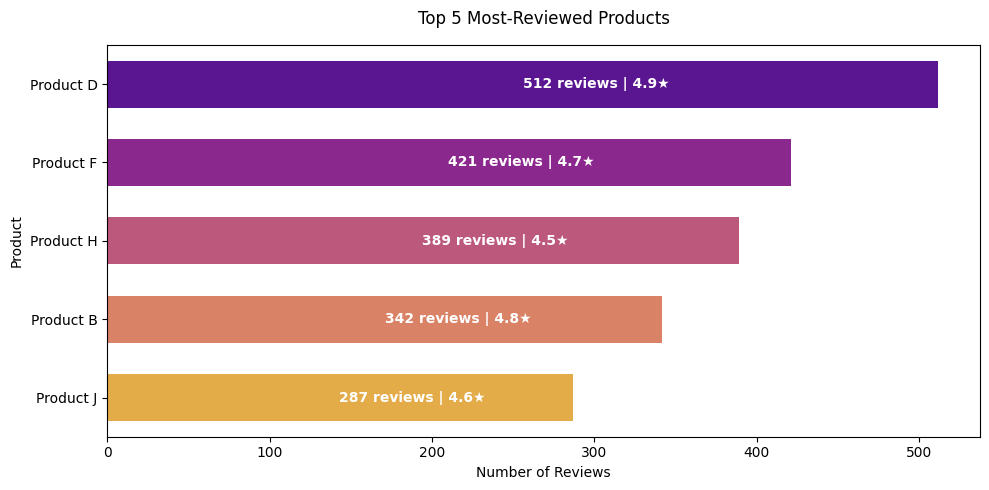

In [101]:
# Get top 5 most-reviewed products
top_reviewed = df.nlargest(5, 'Reviews')

plt.figure(figsize=(10, 5))
bar = sns.barplot(
    x='Reviews',
    y='Title',
    data=top_reviewed,
    palette='plasma',
    width=0.6
)

# Add value labels
for i, (reviews, rating) in enumerate(zip(top_reviewed['Reviews'], top_reviewed['Rating'])):
    plt.text(
        reviews//2,  # X-position (middle of bars)
        i,           # Y-position
        f"{reviews:,} reviews | {rating:.1f}★",
        va='center',
        color='white',
        fontweight='bold'
    )

plt.title('Top 5 Most-Reviewed Products', pad=15)
plt.xlabel('Number of Reviews')
plt.ylabel('Product')
plt.tight_layout()
plt.show()

In [103]:
from IPython.display import display

# Create a merged view with unique names
top_products = pd.concat([
    top_rated.assign(Category='Top Rated'),
    top_reviewed.assign(Category='Most Reviewed')
])

# Add unique identifiers for products appearing in both lists
top_products['Display_Name'] = top_products.apply(
    lambda x: f"{x['Title']} (${x['Price']})" if x['Title'] in
    set(top_rated['Title']).intersection(set(top_reviewed['Title']))
    else x['Title'], axis=1
)

# Reset index for styling
top_products = top_products.reset_index(drop=True)

# Create styled table
styled_table = (top_products[['Display_Name', 'Price', 'Rating', 'Reviews', 'Category']]
                .style
                .bar(subset=['Rating'], color='#5fba7d', vmin=0, vmax=5)
                .bar(subset=['Reviews'], color='#ffa07a')
                .format({'Price': '${:.2f}', 'Rating': '{:.1f}★'})
                .set_properties(**{'text-align': 'left'}))

print("🏆 Product Performance Leaders")
display(styled_table)

🏆 Product Performance Leaders


,Display_Name,Price,Rating,Reviews,Category
0,Product D ($199.99),$199.99,4.9★,512,Top Rated
1,Product B ($89.99),$89.99,4.8★,342,Top Rated
2,Product F ($149.99),$149.99,4.7★,421,Top Rated
3,Product J ($129.99),$129.99,4.6★,287,Top Rated
4,Product H ($249.99),$249.99,4.5★,389,Top Rated
5,Product D ($199.99),$199.99,4.9★,512,Most Reviewed
6,Product F ($149.99),$149.99,4.7★,421,Most Reviewed
7,Product H ($249.99),$249.99,4.5★,389,Most Reviewed
8,Product B ($89.99),$89.99,4.8★,342,Most Reviewed
9,Product J ($129.99),$129.99,4.6★,287,Most Reviewed
